In [1]:
# standard imports
import pandas as pd
import numpy as np
import time 

# import custom netdata stuff from our package
from netdata_api_utils.utils import api, get_metrics

from skmultiflow.anomaly_detection import HalfSpaceTrees
from skmultiflow.data.data_stream import DataStream

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
# define how long to run for
n_max = 1000
n_burn_in = 100
time_sleep = 0.5

# some model params
window_size = 100
size_limit = 0.1*window_size
n_estimators = 50
anomaly_threshold = 0.9
depth = 15

# 'stream' some data in from netdata
for n in range(0,n_max):
    
    # sleep for a bit to make sure samples spread out in time
    time.sleep(time_sleep)
    
    # define some metrics of interest
    metrics_list = ['system.cpu','users.cpu_user','apps.cpu','apps.cpu_user','apps.cpu_system']

    # pull the data
    df = get_metrics(metrics_list,after=-1,before=0)

    # aggregate and get ready for skmultiflow
    df = df.groupby(['timestamp','key']).sum().reset_index()
    df = df.pivot(index='timestamp',columns='key',values='value').reset_index()._get_numeric_data().head(1)

    # set label to assume normal data
    df['label'] = 0
    
    # make stream
    stream = DataStream(df)
    stream.prepare_for_use()
    
    # some set up if first observation
    if n == 0:
        # define anomaly detection learner
        learner = HalfSpaceTrees(
            n_features=stream.n_features, 
            window_size=window_size, 
            n_estimators=n_estimators, 
            size_limit=size_limit, 
            anomaly_threshold=anomaly_threshold,
            depth=depth
        )

        # lists to collect data into
        X_vals = []
        y_preds = []
        y_probs = []
        
    # get X and y
    X, y = stream.next_sample()
    
    # wait until enough burn in data processed
    if n > n_burn_in:
        y_pred = learner.predict(X).tolist()
        y_prob = learner.predict_proba(X).tolist()[0]
        X_vals.append(X.tolist()[0])
        y_preds.append(y_pred)
        y_probs.append(y_prob)
        
    # do partial fit on the observation
    learner.partial_fit(X, y)
    
# put results into a df
df_x = pd.DataFrame(X_vals,columns=stream.feature_names)
df_probs = pd.DataFrame(y_probs,columns=[f'prob_{n}' for n in range(len(y_probs[0]))])
df_preds = pd.DataFrame(y_preds,columns=[f'pred_{n}' for n in range(len(y_preds[0]))])
df = pd.concat([df_x,df_probs,df_preds],axis=1)
print(df.shape)
df.head()

(899, 8)


,apps.cpu,apps.cpu_system,apps.cpu_user,system.cpu,users.cpu_user,prob_0,prob_1,pred_0
0,96.9659,0.0000,96.9659,24.500000,96.9659,5.000000e-01,0.500000,0
1,11.0054,0.0000,11.0054,3.258146,11.0054,6.103516e-07,0.999999,1
2,11.0054,0.0000,11.0054,3.258146,11.0054,6.103516e-07,0.999999,1
3,22.0133,0.9172,21.0961,5.764411,21.0961,6.103516e-07,0.999999,1
4,22.0133,0.9172,21.0961,5.764411,21.0961,6.103516e-07,0.999999,1


In [3]:
# smooth out probs
for p in [col for col in df.columns if 'prob' in col]:
    df[f"smooth_p{p.split('_')[-1]}"] = df[p].rolling(10).mean()

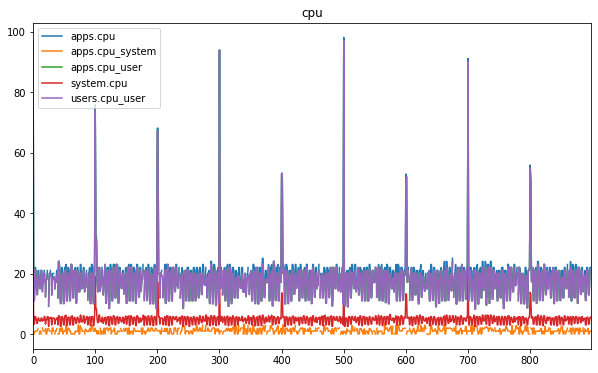

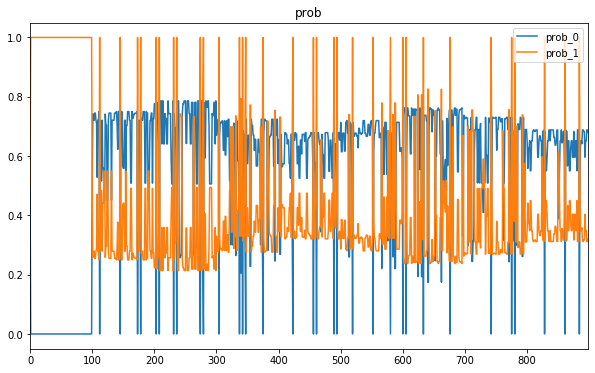

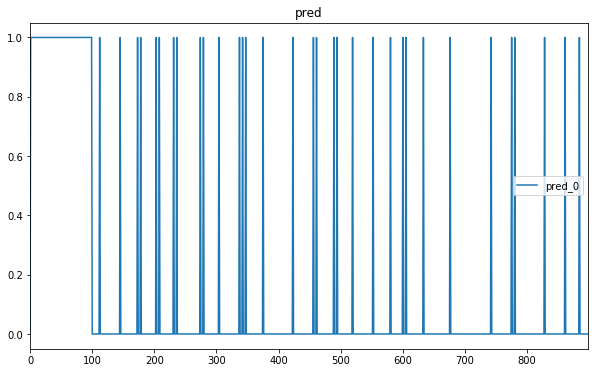

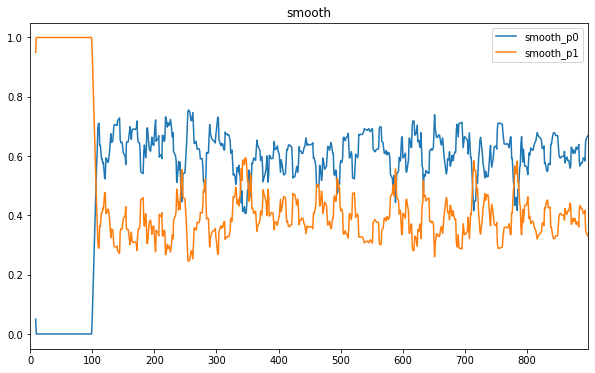

In [4]:
# plot the cols, probs and preds
for prefix in ['cpu','prob','pred','smooth']:
    plot_cols = [col for col in df.columns if prefix in col]
    df[plot_cols].plot(title=prefix, figsize=(10,6))